# SVM for Chemoinformatics : Graph embedding and Graph kernels

The purpose of this practical work is to handle several datasets in order to derive a predictive model. The considered datasets are :
 * MUTAG : 188 molecules associated to a property of being mutagen or not [link]()
 * Acyclic : 183 molecules associated with their boiling points. It thus corresponds to a regression problem.
 * COBRA dataset : 111 molecules with electrophilicity. This dataset has been used in a scientific paper authored in collaboration with COBRA and LITIS.

To derive our predictive models, we will use linear models such as SVM with two related approaches : graph embedding and graph kernels.

## Datasets

First, we will load the datasets we will use. To do so, use the poetry environnement provided to you. It will help to manage the differents libraries.

In [1]:
%load_ext autoreload
%autoreload 2

#check du kernel name de ipykernel
import ipykernel
info= dict(eval(ipykernel.get_connection_info().replace("=",":")))
print(info["kernel_name"])
# devrait afficher ia_pour_la_chimie


ia_pour_la_chimie


In [2]:
%matplotlib inline 

# pour afficher les graphiques dans le notebook

# Utility libraries
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt


### Chargement de MUTAG

Introduced by Debnath et al. in Structure-activity relationship of mutagenic aromatic and heteroaromatic nitro compounds

In particular, MUTAG is a collection of nitroaromatic compounds and the goal is to predict their mutagenicity on Salmonella typhimurium. Input graphs are used to represent chemical compounds, where vertices stand for atoms and are labeled by the atom type (represented by one-hot encoding), while edges between vertices represent bonds between the corresponding atoms. It includes 188 samples of chemical compounds with 7 discrete node labels.

[https://paperswithcode.com/dataset/mutag]

In [3]:
#  for MUTAG
from torch_geometric.datasets import TUDataset
from torch_geometric.utils import to_networkx

dataset_MUTAG = TUDataset("./datasets","MUTAG",use_node_attr=True,use_edge_attr=True)
graphs_MUTAG = [to_networkx(g, node_attrs=["x"],edge_attrs=["edge_attr"],to_undirected=True, remove_self_loops=True) for g in dataset_MUTAG]
graphs_MUTAG = [to_networkx(g, node_attrs=["x"],edge_attrs=["edge_attr"],to_undirected=True, remove_self_loops=True) for g in dataset_MUTAG]
y_MUTAG = dataset_MUTAG.y

In [4]:
from utils import convert_features_names, convert_node_attr_MUTAG

convert_features_names(graphs_MUTAG,cv_node_attr=convert_node_attr_MUTAG,
                       old_name_node="x",new_name_node="atom")

len(graphs_MUTAG)

188

### Chargement de Acyclic

This dataset is originally composed of 185 acyclic molecules (Cherqaoui et al., 1994a) but has been reduced to 183 after identifying two duplicates. This problem consists in predicting boiling point of molecules. These molecules contain several hetero atoms and are thus represented as acyclic labeled graphs. 

>Cherqaoui, D., Villemin, D., Mesbah, A., Cense, J. M., Kvasnicka, V., 1994a. Use of a Neural Network to Determine the Normal Boiling Points of Acyclic Ethers, Peroxides, Acetals and their Sulfur Analogues. J. Chem. Soc. Faraday Trans. 90, 2015–2019.

>Gaüzère, Benoit, Luc Brun, Didier Villemin. 2012. « Two new graphs kernels in chemoinformatics ». Pattern Recognition Letters 33 (15): 2038‑47. https://doi.org/10.1016/j.patrec.2012.03.020.


In [5]:
#load Acyclic dataset from gklearn

from gklearn.dataset import DataLoader
dataset_Acyclic = DataLoader("./datasets/Acyclic/dataset_bps.ds")
#dataset = load_dataset("./graphkit-learn/datasets/Acyclic/dataset_bps.ds")
graphs_Acyclic = dataset_Acyclic.graphs
y_Acyclic = np.array(dataset_Acyclic.targets)

In [6]:
print(len(graphs_Acyclic), len(y_Acyclic))

183 183


### Chargement des données COBRA

This dataset is devoted to predict Mayr's experimental scale for electrophilicity. All electrophiles available in Mayr's Database (319 electrophiles) have been selected and then subjected to successive selections to finally obtain a database made of 111 molecules. Here the graph are described by 19 descriptors and each atom by 50 descriptors, including quantum chemical descriptors. To have more details on the chemical side, see with Vincent Tognetti.

> Hoffmann, Guillaume, Muhammet Balcilar, Vincent Tognetti, Pierre Héroux, Benoit Beno\^\it Gaüzère, Sébastien Adam, et Laurent Joubert. 2020. « Predicting experimental electrophilicities from quantum and topological descriptors: A machine learning approach ». Journal of Computational Chemistry 41 (24): 2124‑36. https://doi.org/10.1002/jcc.26376.



In [7]:
from utils import loadCobraData

cobra_dataset = loadCobraData(fname='./datasets/cobradat_nonnan.mat')

In [8]:

# Let's display some infomations
print('Name of molecule: ', cobra_dataset['mol_names'][0])
print('Name of file: ',cobra_dataset['file_names'][0])
print('Electrophilicy: ',cobra_dataset['graph_electrophilicity'][0])
print('adjagency matrix:')
print(cobra_dataset['adjacency_matrices'][0])
print('Connectivity matrix:')
print(cobra_dataset['connectivity_matrices'][0])
print('Global features of the first molecule')
for i in range(0,len(cobra_dataset['graph_features_names'])):
    print(cobra_dataset['graph_features_names'][i],'  = ', cobra_dataset['graph_features'][0,i])

print('Atomic features of the first molecules 6th atom')

print('Atom Name: ',  cobra_dataset['atom_names'][0][5])
for i in range(0,cobra_dataset['atom_features'][0].shape[1]):
    print(cobra_dataset['atom_features_names'][i],' = ', cobra_dataset['atom_features'][0][5,i])

Name of molecule:  benzylidenemalononitril
Name of file:  1_MV
Electrophilicy:  -9.42
adjagency matrix:
[[0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]]
Connectivity matrix:
[[0.00000000e+00 1.07645207e+00 1.07557669e+00 1.01372181e-01
  1.00646104e-01 1.55893596e+00 5.37200326e-02 6.12910043e-02
  3.40767326e-02 3.07601122e-02 4.14605266e-03 1

In [13]:
from utils import clean_cobra_atom_data
from utils import clean_cobra_graph_data
X_cobra_graph = clean_cobra_graph_data(cobra_dataset)
X_cobra_atom = clean_cobra_atom_data(cobra_dataset)
print(X_cobra_graph.shape)

(111, 3)
(111, 20) (111, 200)


## Graph Embedding

First, we will compute some descriptors for Acyclic so as to be able to run a SVM of this graph features. To do so, we will use the Morgan Fingerprint algorithm which extracts the number of occurences of some substructures, and store this data into a fixed size vector.

The matrix visualization will help you to check the embeddings of the graph. 

1) Complete the code so as `X_acyclic` contains the embeddings of graphs included in `graphs_Acyclic`
1) In this `X_acyclic` matrix, what does represent a line and a column ?
2) What do you think about this embedding ?

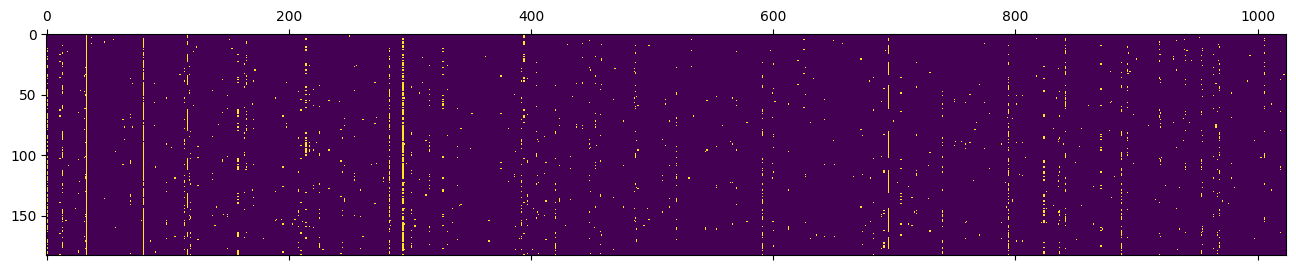

In [14]:
from utils import compute_embeddings

X_Acyclic = compute_embeddings(graphs_Acyclic)

plt.matshow(X_Acyclic)
plt.show()

In this matrix, each line corresponds to a molecule encoded as a 1024 vector. 



Now we will derive a predictive model which aim to output the boiling point of each molecule.

1) Complete the code to split the dataset between a train and a test set. Why this step is required ?
2) Complete the code to fit a linear SVM using the train set
3) Compute the mean absolute error of the prediction on both train and test set. Comment.

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error


X_train, X_test, y_train, y_test = train_test_split(X_Acyclic, y_Acyclic, test_size=0.1, random_state=42)

clf = SVR(kernel='linear')
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(mean_absolute_error(y_train, y_pred_train))
print(mean_absolute_error(y_test, y_pred_test))



24.322253390360718
24.61227815129803


SVR method comes with several hyperparameters which can be tuned so as to have a better regressor. We will identify some hyperparameters and tune them in a proper way.

1) What are the hyperparameters of SVR ?
2) What protocol do you propose to tune them ?
3) Complete the code so as to fit the hyperparameters.
4) Compute your performance.

In [16]:
from sklearn.model_selection import GridSearchCV

parameters = {'kernel':['rbf'], 'C':[1, 10,100,1000,10000],'epsilon':[0.1,0.5,1,4],'gamma':[0.1,0.2,0.5,1,'auto','scale']}
svr = SVR()
clf = GridSearchCV(svr, parameters)
clf.fit(X_train, y_train)

y_pred_train = clf.predict(X_train)
y_pred_test = clf.predict(X_test)

print(mean_absolute_error(y_train, y_pred_train))
print(mean_absolute_error(y_test, y_pred_test))


4.869641160669886
12.437871069505807


We will now switch to COBRA dataset. First, let's use only the graph features and a linear regression. Note that in this case, we don't have any hyperparameters.

1) Complete the code to use a linear regression (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)
2) Compare to the results of the paper



In [17]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
mae_runs = []

linear_reg = LinearRegression()

mae_runs=[]
for _ in tqdm(range(100)):
    X_train, X_test, y_train, y_test = train_test_split(X_cobra_graph, 
                                                        cobra_dataset['graph_electrophilicity'], 
                                                        test_size=0.1)

    linear_reg.fit(X_train, y_train)

    y_pred_train = linear_reg.predict(X_train)
    y_pred_test = linear_reg.predict(X_test)

    mae_runs.append(mean_absolute_error(y_test, y_pred_test))
print(np.mean(mae_runs), np.std(mae_runs))

100%|██████████| 100/100 [00:00<00:00, 1132.72it/s]

2.1089460924655903 0.9763586207774739


## Graph Kernel

The limitations of graph embeddings is that we have to use the provided features, and only combine them. To go further, let's implement some graph kernels on both graphs and graph embeddings.

### COBRA

Given COBRA dataset, we will first apply kernels to the vectorial representation of graphs and atoms. In this section, we will aim to reproduce some of the results of the initial paper.

1) Complete the code to test a rbf kernel with C = 100 or 1000, epsilon to 0.2 or 1 and gamma to 0.0001, 0.001 and 1
2) What is the caveat to add too much hyperparameters to test ?
3) What part of the table 1 of the paper we are trying to reproduce ?

In [18]:
# Global inputs
parameters = {'kernel':['rbf'],
               'C':[10,50,100,200,500,1000,],
               'epsilon':[0.1,.2,0.5,1],
               'gamma':['auto','scale']}



mae_runs=[]
for _ in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X_cobra_graph, 
                                                        cobra_dataset['graph_electrophilicity'], 
                                                        test_size=0.1)

    clf = GridSearchCV(svr, parameters,n_jobs=-1,cv =5, scoring='neg_mean_absolute_error')
    clf.fit(X_train, y_train)
    

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    
    mae_runs.append(mean_absolute_error(y_test, y_pred_test))

print(np.mean(mae_runs), np.std(mae_runs))

100%|██████████| 10/10 [00:03<00:00,  3.29it/s]

1.6571503668608016 0.41644385851172644


Note that among the possible descriptors, `atom features` depends on the number of atom of each molecule and has thus a variable number of length, hence forbiding the representation of each molecule as fixed size vector. To avoid this drawback, we  encoded each atom feature by 4 statistics : min, max, mean and standard deviation.

> Warning : more features than data !

1) In the same way, complete the code to compute the performance of these molecular descriptors.
2) What line of table 1 of the paper you are trying to reproduce.

In [19]:
parameters = {'kernel':['rbf'],
               'C':[0.1,1,10,100,1000, 10000],
               'epsilon':[0.1,0.2,0.5,1,5, 10],
               'gamma':[1e-5,1e-4,1e-3,1e-2,'auto','scale']}


mae_runs=[]
for _ in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X_cobra_atom, 
                                                        cobra_dataset['graph_electrophilicity'], 
                                                        test_size=0.1)

    clf = GridSearchCV(svr, parameters,n_jobs=-1,cv =10, scoring='neg_mean_absolute_error')
    clf.fit(X_train, y_train)
    

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    mae_runs.append(mean_absolute_error(y_test, y_pred_test))

print(np.mean(mae_runs), np.std(mae_runs))


100%|██████████| 10/10 [00:09<00:00,  1.02it/s]

1.5759805297067948 0.7301107417577837


1) Complete the following code to use both graph and atom features.
2) Comment your approach and results

In [20]:
X_cobra_graph_atom = np.concatenate((X_cobra_graph,X_cobra_atom),axis=1)

parameters = {'kernel':['rbf'],
               'C':[0.1,1,10,100,1000, 10000],
               'epsilon':[0.1,0.2,0.5,1,2],
               'gamma':[1e-5,1e-4,1e-3,1e-2,'auto','scale']}

mae_runs=[]
for _ in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split(X_cobra_graph_atom, 
                                                        cobra_dataset['graph_electrophilicity'], 
                                                        test_size=0.1)

    clf = GridSearchCV(svr, parameters,n_jobs=-1,cv =10, scoring='neg_mean_absolute_error')
    clf.fit(X_train, y_train)
    

    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)

    mae_runs.append(mean_absolute_error(y_test, y_pred_test))

print(np.mean(mae_runs), np.std(mae_runs))


100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

1.3023625208993646 0.8215961407183416


In the previous experiments, we compared three approaches. What can you propose to improve the equity of this comparison ? 

In [21]:
# run the same three experiments on the same 10 splits for the COBRA dataset
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
from tqdm import tqdm
import numpy as np

# Initialiser le modèle SVR
svr = SVR()

# Liste pour stocker les divisions
splits = []
n=X_cobra_graph.shape[0]
# Créer les divisions et les stocker
for _ in range(10):
    idx_train,idx_test = train_test_split(np.arange(n), test_size=0.1)
    splits.append((idx_train,idx_test))

def evaluate_model(X,y, parameters, splits):
    mae_runs = []
    
    for (idx_train, idx_test) in tqdm(splits):
        
        clf = GridSearchCV(svr, parameters, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error')
        clf.fit(X[idx_train, :], y[idx_train])
        y_pred_test = clf.predict(X[idx_test,:])
        mae_runs.append(mean_absolute_error(y[idx_test], y_pred_test))
    return np.mean(mae_runs), np.std(mae_runs)

# Parameters and Data for each method
X_cobra_graph_atom = np.concatenate((X_cobra_graph,X_cobra_atom),axis=1)
parameters = {'kernel':['rbf'], 
              'C':[0.1,1,10,100,1000,10000], 
              'epsilon':[0.1,0.2,0.5,1,5,10],
              'gamma':[1e-5,1e-4,1e-3,1e-2]}
methods = [
    {"name": "Global inputs", "X": X_cobra_graph},
    {"name": "Atom inputs", "X": X_cobra_atom},
    {"name": "Combined inputs",  "X": X_cobra_graph_atom}
]

for method in methods:
    mean_mae, std_mae = evaluate_model(method["X"], cobra_dataset['graph_electrophilicity'], parameters, splits)
    print(f"{method['name']}: Mean MAE = {mean_mae:.2f}, Std MAE = {std_mae:.2f}")


100%|██████████| 10/10 [00:08<00:00,  1.18it/s]


Global inputs: Mean MAE = 1.38, Std MAE = 0.40


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]


Atom inputs: Mean MAE = 1.26, Std MAE = 0.32


100%|██████████| 10/10 [00:07<00:00,  1.31it/s]

Combined inputs: Mean MAE = 1.20, Std MAE = 0.37


### MUTAG

For this second experiment, we will directly compute some graph kernels without passing by an embedding of the graphs. To do so, we will test the Path kernel and the Treelet kernel. The aim is to compare the two methods on a classification problem.

1) On a classification problem, what predictive model can you use ?
2) What are the dimension of both gram matrices, and what do they reprensent ?

In [22]:
from gklearn.kernels import PathUpToH
from gklearn.kernels import Treelet
from gklearn.utils.kernels import gaussian_kernel
import functools



# Initailize parameters for graph kernel computation.
kernel_options = {'depth': 3,'k_func': 'MinMax','compute_method': 'trie'}
# Initialize graph kernel.
graph_kernel_path = PathUpToH(node_labels=['atom'], # list of node label names.
						 #ds_infos=dataset.get_dataset_infos(keys=['directed']), # dataset information required for computation.
						 **kernel_options, # options for computation.
						 )

graph_kernel_treelet = Treelet(node_labels=['atom'], # list of node label names.)
                       sub_kernel = functools.partial(gaussian_kernel, gamma=0.0005) , # Sub-kernel for computing treelet kernel.
                       ds_infos = {'directed': False}, # dataset information required for computation.
								)

# Compute Gram matrix.
gram_matrix_treelet, _ = graph_kernel_treelet.compute(graphs_MUTAG)
gram_matrix_path, _ = graph_kernel_path.compute(graphs_MUTAG)



getting canonkeys: 188it [00:00, 619.85it/s]
Computing kernels: 17766it [00:03, 4830.43it/s]
Gram matrix of size 188 built in 4.322350025177002 seconds.
getting paths: 188it [00:00, 1249.14it/s]
Computing kernels: 17766it [00:01, 10180.39it/s]
Gram matrix of size 188 built in 2.2319672107696533 seconds.


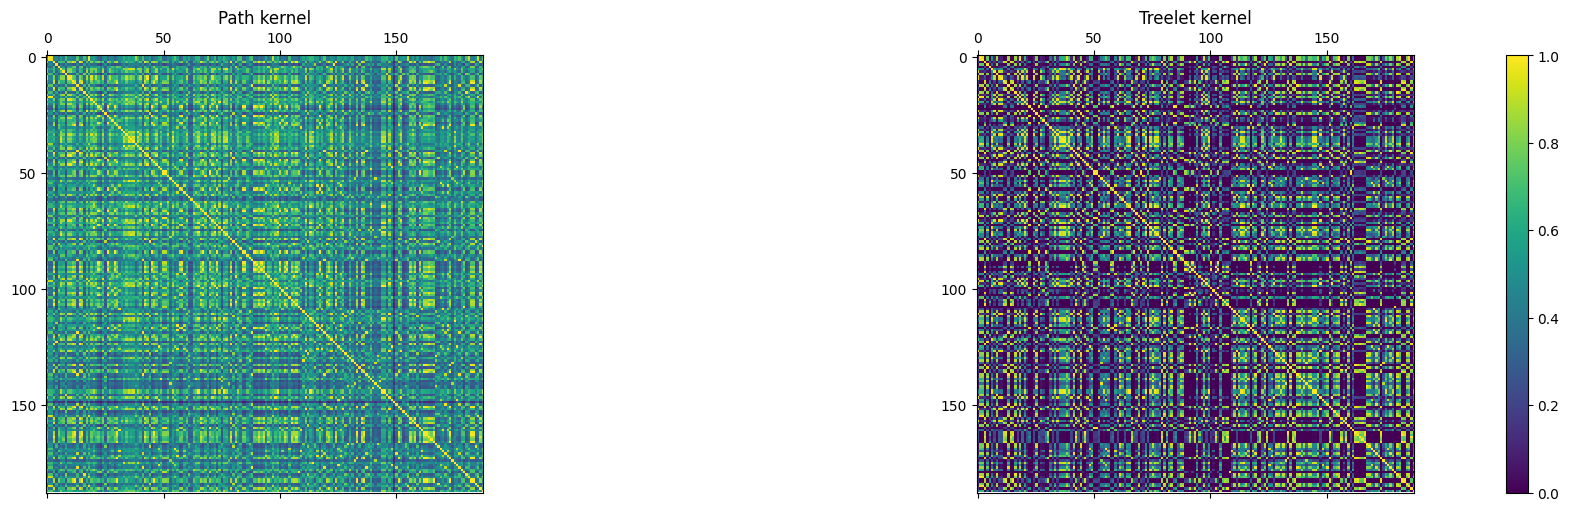

In [23]:
%matplotlib inline
# Print results.

mosaic = "AB"
fig = plt.figure(layout="constrained",figsize=(20,5) )
ax_dict = fig.subplot_mosaic(mosaic)

# Compute vmin and vmax for both matrices
vmin = min(np.min(gram_matrix_path), np.min(gram_matrix_treelet))
vmax = max(np.max(gram_matrix_path), np.max(gram_matrix_treelet))

im1 = ax_dict["A"].matshow(gram_matrix_path, vmin=vmin, vmax=vmax)
ax_dict["A"].set_title("Path kernel")

im2 = ax_dict["B"].matshow(gram_matrix_treelet, vmin=vmin, vmax=vmax)
ax_dict["B"].set_title("Treelet kernel")

# Add colorbar
fig.colorbar(im1, ax=[ax_dict["A"], ax_dict["B"]])


Now, we will compute a SVM C model to build a predictive model based on this two kernels. 

1) Check the sklearn documentation to understand how to use our kernels
2) What are the hyperparameters to tune ?
3) Compare the two methods. What metric do you use ? 

In [24]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

parameters = {'kernel':['precomputed'],
               'C':np.logspace(-2,6,20)
               }


def train_test_split_gram(gram_matrix, y, test_size=0.1):
    n_samples = gram_matrix.shape[0]
    # Créez un index pour diviser la matrice
    indices = np.arange(n_samples)
    train_indices, test_indices = train_test_split(indices, test_size=test_size)
    gram_matrix_train = gram_matrix[train_indices][:, train_indices]
    gram_matrix_test = gram_matrix[test_indices][:, train_indices]

    y_train = y[train_indices]
    y_test = y[test_indices]
    return gram_matrix_train, gram_matrix_test, y_train, y_test

svc = SVC()  
accuracies_path = {"train":[],"val":[],"test":[]}


for _ in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split_gram(gram_matrix_path,y_MUTAG,test_size=0.1)
    clf = GridSearchCV(svc, parameters,n_jobs=-1,cv =10, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracies_path["test"].append(accuracy_score(y_test, y_pred_test))
    accuracies_path["train"].append(accuracy_score(y_train, y_pred_train))
    accuracies_path["val"].append(clf.best_score_)
    
print(f"Mean and std accuracies with Path Kernel : {np.mean(accuracies_path['test']):.2f}, {np.std(accuracies_path['test']):.2f}")

accuracies_treelet = {"train":[],"val":[],"test":[]}

for _ in tqdm(range(10)):
    X_train, X_test, y_train, y_test = train_test_split_gram(gram_matrix_treelet,y_MUTAG,test_size=0.1)
    clf = GridSearchCV(svc, parameters,n_jobs=-1,cv =10, scoring='accuracy')
    clf.fit(X_train, y_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracies_treelet["test"].append(accuracy_score(y_test, y_pred_test))
    accuracies_treelet["train"].append(accuracy_score(y_train, y_pred_train))
    accuracies_treelet["val"].append(clf.best_score_)

    
print(f"Mean and std accuracies with Treelet Kernel : {np.mean(accuracies_treelet['test']):.2f}, {np.std(accuracies_treelet['test']):.2f}")



100%|██████████| 10/10 [00:04<00:00,  2.10it/s]


Mean and std accuracies with Path Kernel : 0.88, 0.07


100%|██████████| 10/10 [00:02<00:00,  3.79it/s]

Mean and std accuracies with Treelet Kernel : 0.83, 0.07


In [25]:
from IPython.display import display, HTML
from tabulate import tabulate

def display_table(accuracies_path, accuracies_treelet):
    headers = ["Kernel", "Train", "Val", "Test"]
    table_data = []

    for kernel, accuracies in [("Path Kernel", accuracies_path), ("Treelet Kernel", accuracies_treelet)]:
        train_str = f"{np.mean(accuracies['train']):.2f} ± {np.std(accuracies['train']):.2f}"
        val_str = f"{np.mean(accuracies['val']):.2f} ± {np.std(accuracies['val']):.2f}"
        test_str = f"{np.mean(accuracies['test']):.2f} ± {np.std(accuracies['test']):.2f}"

        table_data.append([kernel, train_str, val_str, test_str])

    display(HTML(tabulate(table_data, headers=headers, tablefmt='html')))

display_table(accuracies_path, accuracies_treelet)




Kernel,Train,Val,Test
Path Kernel,0.96 ± 0.01,0.90 ± 0.01,0.88 ± 0.07
Treelet Kernel,0.92 ± 0.04,0.88 ± 0.01,0.83 ± 0.07


### Acyclic

Here, we will compare our graph kernel methods together, but also with the first results obtained only using an embedding.

1) Complete the code to compute the two graph kernels on the Acyclic dataset
2) Visualize the Gram matrices. What do you think about your gamma parameter choice ? Understand what is happening and try to improve it. 

In [36]:
# Initailize parameters for graph kernel computation.
kernel_options = {'depth': 3,'k_func': 'MinMax','compute_method': 'trie'}
# Initialize graph kernel.
graph_kernel_path = PathUpToH(node_labels=['atom_symbol'], # list of node label names.
						 #ds_infos=dataset.get_dataset_infos(keys=['directed']), # dataset information required for computation.
						 **kernel_options, # options for computation.
						 )

#V1
graph_kernel_treelet = Treelet(node_labels=['atom_symbol'], # list of node label names.)
                       sub_kernel = functools.partial(gaussian_kernel, gamma=0.0001) , # Sub-kernel for computing treelet kernel.
                       ds_infos = {'directed': False}, # dataset information required for computation.
								)

#V2
graph_kernel_treelet = Treelet(node_labels=['atom_symbol'], # list of node label names.)
                       sub_kernel = functools.partial(gaussian_kernel, gamma=0.01) , # Sub-kernel for computing treelet kernel.
                       ds_infos = {'directed': False}, # dataset information required for computation.
								)

# Compute Gram matrix.
gram_matrix_treelet, _ = graph_kernel_treelet.compute(graphs_Acyclic)
gram_matrix_path, _ = graph_kernel_path.compute(graphs_Acyclic)


getting canonkeys: 183it [00:00, 1737.27it/s]
Computing kernels: 16836it [00:01, 15202.27it/s]
Gram matrix of size 183 built in 1.5607469081878662 seconds.
getting paths: 183it [00:00, 3353.42it/s]
Computing kernels: 16836it [00:00, 29662.04it/s]
Gram matrix of size 183 built in 0.9498178958892822 seconds.


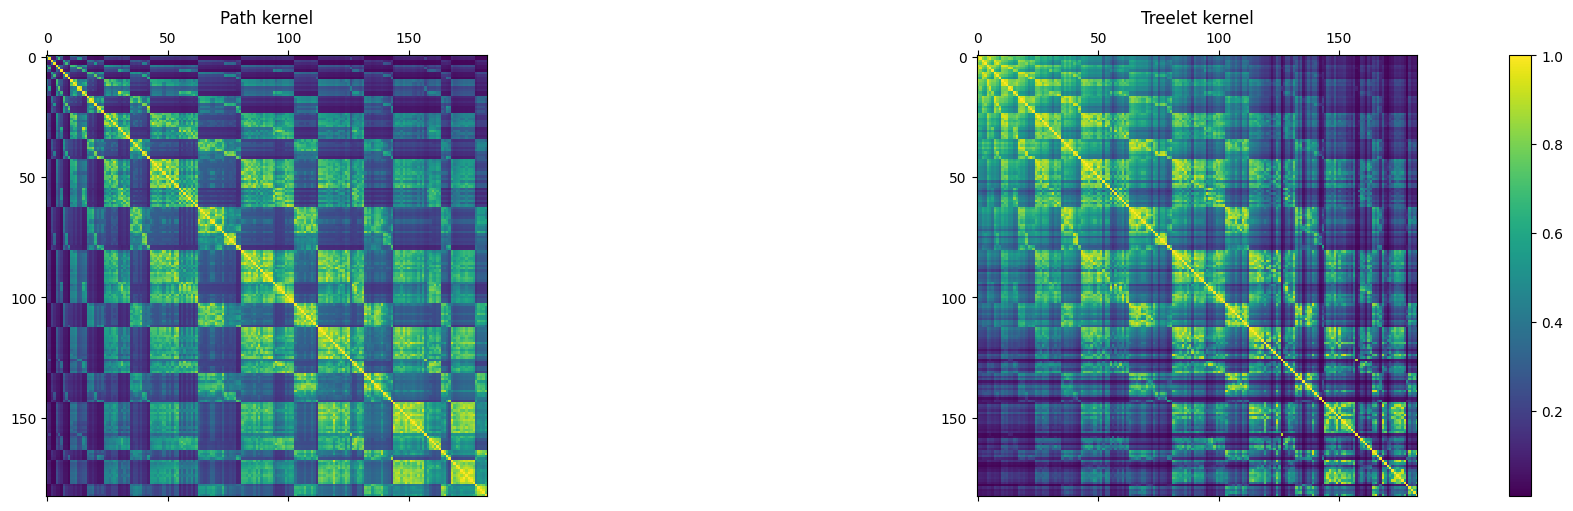

In [37]:
%matplotlib inline
# Print results.

mosaic = "AB"
fig = plt.figure(layout="constrained",figsize=(20,5) )
ax_dict = fig.subplot_mosaic(mosaic)

# Compute vmin and vmax for both matrices
vmin = min(np.min(gram_matrix_path), np.min(gram_matrix_treelet))
vmax = max(np.max(gram_matrix_path), np.max(gram_matrix_treelet))

im1 = ax_dict["A"].matshow(gram_matrix_path, vmin=vmin, vmax=vmax)
ax_dict["A"].set_title("Path kernel")

im2 = ax_dict["B"].matshow(gram_matrix_treelet, vmin=vmin, vmax=vmax)
ax_dict["B"].set_title("Treelet kernel")

# Add colorbar
fig.colorbar(im1, ax=[ax_dict["A"], ax_dict["B"]])


Now, we will check in details the influence of `C` parameter.

1) Complete the code to split the data into train and test and learn a SVR with default hyperparameters.
2) What is the train and test performances ? What is the default value for `C` ? 

In [28]:
svr = SVR(kernel="precomputed")
X_train, X_test, y_train, y_test = train_test_split_gram(gram_matrix_treelet,y_Acyclic,test_size=0.1)
svr.fit(X_train, y_train)
y_pred_train = svr.predict(X_train)
y_pred_test = svr.predict(X_test)
print(mean_absolute_error(y_train, y_pred_train))    
print(mean_absolute_error(y_test, y_pred_test))    

print(f"{svr.C = }")


32.624361759489695
22.627181930656054
svr.C = 1.0


1) Based on your understanding of SVM, how to tune the `C` parameter to reduce the training error ? 
2) Plot the MAE on train set for `C=1,10,100,1000,10000,100000`
3) Do the same with MAE on test set
4) What is the best value for `C` ? Why ?

In [29]:
C_values = [1,10,100,1000,10000,10000000]

mae_train_C = []
mae_test_C = []

for C in C_values:
    svr = SVR(kernel="precomputed",C=C)
    svr.fit(X_train, y_train)
    y_pred_train = svr.predict(X_train)
    y_pred_test = svr.predict(X_test)
    mae_train_C.append( mean_absolute_error(y_train, y_pred_train))
    mae_test_C.append(mean_absolute_error(y_test, y_pred_test))  
    

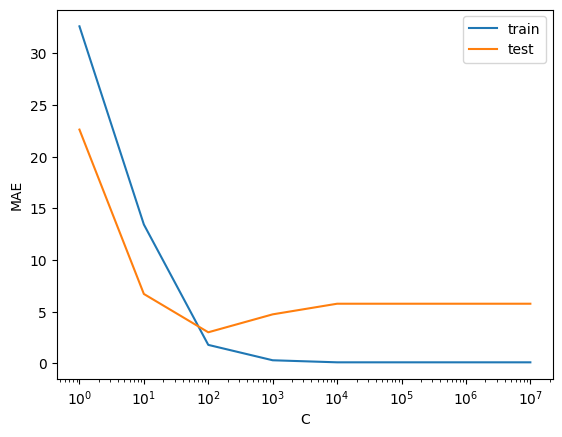

In [30]:
plt.plot(C_values,mae_train_C,label="train")
plt.plot(C_values,mae_test_C,label="test")
plt.xscale('log')
plt.xlabel('C')
plt.ylabel('MAE')
plt.legend()
plt.show()


In [31]:
parameters = {'kernel':['precomputed'], 
              'C':np.logspace(-2,6,10),
              'epsilon':np.logspace(-1,1,10)}
methods = [
    {"name": "Treelet Kernel", "K": gram_matrix_treelet},
    {"name": "Path Kernel", "K": gram_matrix_path},
]

splits = []
n=gram_matrix_path.shape[0]
# Créer les divisions et les stocker
for _ in range(10):
    idx_train,idx_test = train_test_split(np.arange(n), test_size=0.1)
    splits.append((idx_train,idx_test))

def evaluate_model_gram(K,y, parameters, splits):
    mae_runs = []
    
    for (idx_train, idx_test) in tqdm(splits):
        K_train = K[idx_train][:,idx_train] 
        K_test = K[idx_test][:,idx_train]
        clf = GridSearchCV(svr, parameters, n_jobs=-1, cv=10, scoring='neg_mean_absolute_error')
        
        clf.fit(K_train, y[idx_train])
        y_pred_test = clf.predict(K_test)
        mae_runs.append(mean_absolute_error(y[idx_test], y_pred_test))
    return np.mean(mae_runs), np.std(mae_runs)

for method in methods:
    mean_mae, std_mae = evaluate_model_gram(method["K"], y_Acyclic, parameters, splits)
    print(f"{method['name']}: Mean MAE = {mean_mae:.2f}, Std MAE = {std_mae:.2f}")


100%|██████████| 10/10 [00:11<00:00,  1.12s/it]


Treelet Kernel: Mean MAE = 5.85, Std MAE = 1.23


100%|██████████| 10/10 [00:06<00:00,  1.44it/s]

Path Kernel: Mean MAE = 5.50, Std MAE = 1.80


Which hyperparameter do you still have to tune ?

## BONUS

Now, you can play with other datasets, kernels or propose your own way to compare molecules. You can have a look to these links:

* https://ls11-www.cs.tu-dortmund.de/staff/morris/graphkerneldatasets
* https://brunl01.users.greyc.fr/CHEMISTRY/
* https://ysig.github.io/GraKeL/
 